# Smoothing metric

In [1]:
%cd work/notebooks

/home/jovyan/work/notebooks


In [2]:
# Import modules and R
import numpy as np, pandas as pd
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

In [347]:
# Import local code
import sys
sys.path.append('../code')
from gradientVersion import *
from processing_helpers import *
from analysis_helpers import *
%R source("../code/Rplots.R");
%R source("../code/brainPlots.R");

In [4]:
pca = gradientVersion(approach='pca', kernel=None).fit('hcp_base')
pca_hcp_3d_ds8 = gradientVersion(approach='pca', kernel=None).fit('hcp_3donors_ds8')
dm_hcp_ds8 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('hcp_ds8')
dm_hcp_3d_ds5 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('hcp_3donors_ds5')

New gradients version: method=pca, params={}, kernel=None, sparsity=0, data=hcp_base
New gradients version: method=pca, params={}, kernel=None, sparsity=0, data=hcp_3donors_ds8
New gradients version: method=dm, params={'alpha': 1}, kernel=normalized_angle, sparsity=0, data=hcp_ds8
New gradients version: method=dm, params={'alpha': 1}, kernel=normalized_angle, sparsity=0, data=hcp_3donors_ds5


## Moran's I

In [361]:
versions_dict = {
    'pca': pca,
    'pca_hcp_3d_ds8': pca_hcp_3d_ds8,
    'dm_hcp_3d_ds5': dm_hcp_3d_ds5,
    'dm_hcp_ds8': dm_hcp_ds8,
}
moran_Is = {}
for name, version in versions_dict.items():
    _scores = version.clean_scores().iloc[:,:3]
    moran_Is[name] = _scores.apply(get_moran_I, pct_include=25)

pd.concat(moran_Is, axis=1)

,pca,pca_hcp_3d_ds8,dm_hcp_3d_ds5,dm_hcp_ds8
G1,0.497240,0.463211,0.485262,0.511464
G2,0.227112,0.661179,0.583136,0.489002
G3,-0.006063,0.218570,0.206315,0.292095


In [372]:
# moran_Is = {}
# for pct in np.linspace(5,100,20):
#     _moran_Is_pct = {}
#     for name, version in versions_dict.items():
#         _scores = version.clean_scores().iloc[:,:3]
#         _moran_Is_pct[name] = _scores.apply(get_moran_I, pct_include=pct)
#     moran_Is[pct] = pd.concat(_moran_Is_pct)

moranI = pd.concat(moran_Is).reset_index().set_axis(['pct','version','G','moranI'], axis=1)

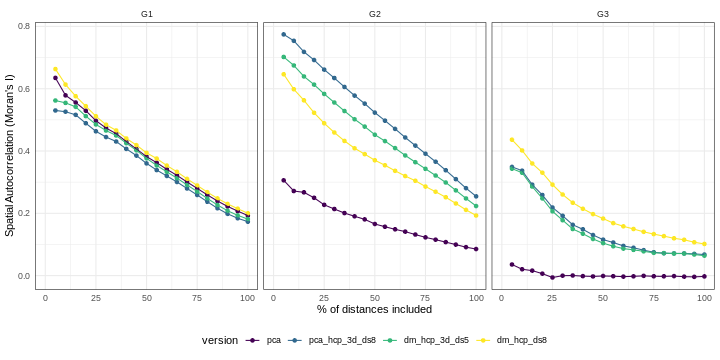

In [392]:
%%R -w 10 -h 5 --units in -i moranI
moranI %>% 
mutate(version=factor(version, ordered=T, levels=unique(.$version))) %>%
ggplot(aes(x=pct, y=moranI, color=version)) + 
facet_grid(.~G) +
geom_point() +
geom_line(aes(group=version)) +
scale_x_continuous(name='% of distances included',
                   limits=c(0,100)) +
ylab("Spatial Autocorrelation (Moran's I)") +
theme_minimal() + 
theme(legend.position='bottom',
      panel.border=element_rect(fill=NA)
)

In [ ]:
versions_dict = {
    'pca': pca,
    'pca_hcp_3d_ds8': pca_hcp_3d_ds8,
    'dm_hcp_3d_ds5': dm_hcp_3d_ds5,
    'dm_hcp_ds8': dm_hcp_ds8,
}
moran_Is = {}
for name, version in versions_dict.items():
    _scores = version.clean_scores().iloc[:,:3]
    moran_Is[name] = _scores.apply(get_moran_I, pct_include=70)

pd.concat(moran_Is, axis=1)

,pca,pca_hcp_3d_ds8,dm_hcp_3d_ds5,dm_hcp_ds8
G1,0.300406,0.279614,0.291053,0.310500
G2,0.131744,0.417362,0.364054,0.304454
G3,-0.000830,0.081653,0.077943,0.140490


In [ ]:
versions_dict = {
    'pca': pca,
    'pca_hcp_3d_ds8': pca_hcp_3d_ds8,
    'dm_hcp_3d_ds5': dm_hcp_3d_ds5,
    'dm_hcp_ds8': dm_hcp_ds8,
}
moran_Is = {}
for name, version in versions_dict.items():
    moran_Is[name] = version.clean_scores().iloc[:,:3].apply(get_moran_I)

pd.concat(moran_Is, axis=1)

,pca,pca_hcp_3d_ds8,dm_hcp_3d_ds5,dm_hcp_ds8
G1,0.192633,0.173108,0.181385,0.199954
G2,0.085261,0.254404,0.223288,0.192905
G3,-0.002666,0.067552,0.063900,0.101585


In [358]:
scores = pca.clean_scores()['G1']
scores = pca.scores[0]
# scores = pca.clean_scores()['G3']
inds = [i-1 for i in scores.index]
distmat = '../data/LeftParcelGeodesicDistmat.txt'
distmat=np.loadtxt(distmat)[inds,:][:, inds]

# # Get indices of region pairs
triangle = np.triu_indices(scores.shape[0], k=1)

distances = distmat[triangle]

pct_include=70
include = distances < np.percentile(distances, pct_include)
len(triangle[0])

# Get weights as 1/distance
# w_ij = 1/distmat[triangle]
# z_i = scores.values[triangle[0]]
# z_j = scores.values[triangle[1]]

15753

In [342]:
w_ij = 1/distmat[triangle]
z_i = scores.values[triangle[0]]
z_j = scores.values[triangle[1]]

In [343]:
(len(scores) / np.sum(w_ij)) * np.sum(w_ij * z_i * z_j) / np.sum(np.square(scores))

0.19263321708362693

In [ ]:
(len(scores) / np.sum(w_ij)) * np.sum(w_ij * z_i * z_j) / np.sum(np.square(scores))

0.19263321708362693

## Variograms

In [270]:
versions_dict = {
    'pca': pca,
    'pca_hcp_3d_ds8': pca_hcp_3d_ds8,
    'dm_hcp_3d_ds5': dm_hcp_3d_ds5,
    'dm_hcp_ds8': dm_hcp_ds8,
}
slopes = {}
variograms = {}
for name, version in versions_dict.items():
    slopes[name], variograms[name] = get_version_variograms(version.clean_scores(),
                                                            n_bins=50, 
                                                            smoothed=True)

variograms = pd.concat(variograms).reset_index(level=0).rename({'level_0':'version'},axis=1)
slopes = pd.concat(slopes).reset_index(level=0).rename({'level_0':'version'},axis=1)
variograms

,version,G,distance,variance,counts,include
0,pca,G1,8.856882,0.185693,33,True
1,pca,G1,12.732300,0.206093,106,True
2,pca,G1,16.607719,0.239577,156,True
3,pca,G1,20.483137,0.279924,169,True
4,pca,G1,24.358555,0.305499,197,True
...,...,...,...,...,...,...
45,dm_hcp_ds8,G3,183.190948,0.756930,53,False
46,dm_hcp_ds8,G3,187.081306,0.708403,24,False
47,dm_hcp_ds8,G3,190.971664,0.671818,10,False
48,dm_hcp_ds8,G3,194.862022,0.640659,7,False


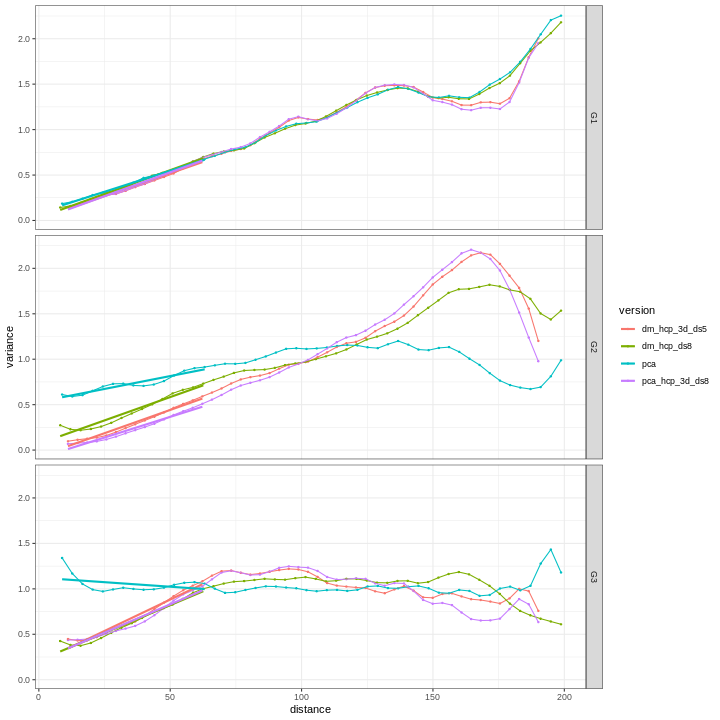

In [271]:
%%R -w 10 -h 10 --units in -i slopes -i variograms
ggplot(variograms, aes(x=distance, y=variance, color=version)) + 
facet_grid(G~.) +
geom_point(size=.5) + 
geom_line(aes(x=distance, y=variance, color=version, group=version)) + 
geom_smooth(method='lm', data=variograms %>% filter(include), se=F) +
theme_bw()

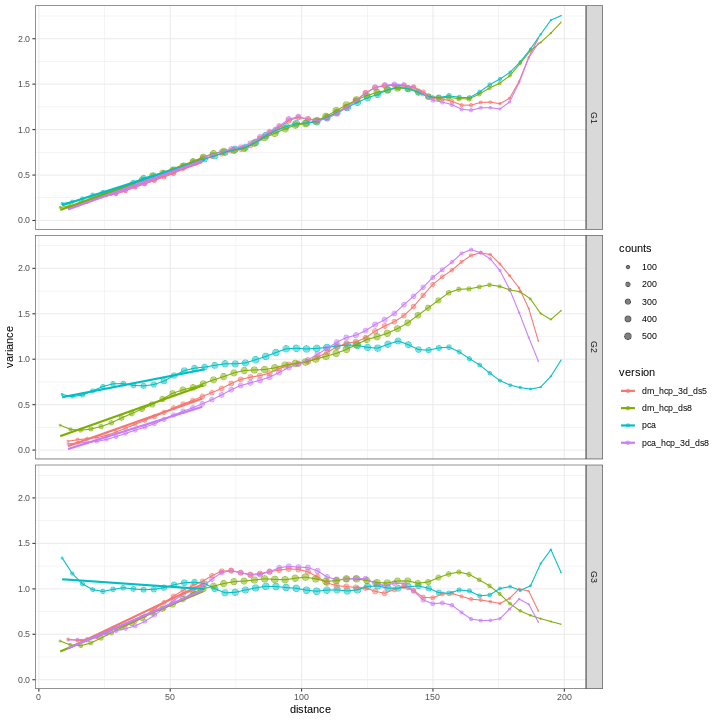

In [288]:
%%R -w 10 -h 10 --units in -i slopes -i variograms
ggplot(variograms, aes(x=distance, y=variance, color=version)) + 
facet_grid(G~.) +
geom_point(aes(size=counts), alpha=.5) + 
geom_line(aes(x=distance, y=variance, color=version, group=version)) + 
geom_smooth(method='lm', data=variograms %>% filter(include), se=F) +
scale_size_continuous(range=c(.2,3)) +
theme_bw()

In [265]:
slopes.sort_index()

,version,Intercept,distance
G1,pca,0.040347,0.010229
G1,pca_hcp_3d_ds8,-0.029572,0.011244
G1,dm_hcp_3d_ds5,-0.017216,0.010791
G1,dm_hcp_ds8,-0.000302,0.011048
G2,pca,0.530086,0.005630
G2,pca_hcp_3d_ds8,-0.123770,0.009839
G2,dm_hcp_3d_ds5,-0.106908,0.011039
G2,dm_hcp_ds8,0.076858,0.010132
G3,pca,1.174498,-0.002674
G3,pca_hcp_3d_ds8,0.206684,0.012266


Filter distance matrix to match non-missing scores

In [101]:
scores = dm_hcp_3d_ds5.scores.iloc[:,0]
inds = [i-1 for i in scores.index]
distmat = np.loadtxt('../data/LeftParcelGeodesicDistmat.txt')
distmat = distmat[inds, :][:, inds]

Get indices of each region pair (from upper triangle of matrix, no diagonal) 

In [76]:
triangle = np.triu_indices(scores.shape[0], k=1)

Get distances and bin

In [83]:
x = distmat[triangle]
bin_edges = np.histogram(x, bins=25)[1]
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
bin_inds = np.digitize(x, bin_edges[:-1]) # drop rightmost edge to include max value

In [130]:
bin_centers

array([ 14.71593065,  21.96766005,  29.21938944,  36.47111883,
        43.72284822,  50.97457762,  58.22630701,  65.4780364 ,
        72.7297658 ,  79.98149519,  87.23322458,  94.48495398,
       101.73668337, 108.98841276, 116.24014215, 123.49187155,
       130.74360094, 137.99533033, 145.24705973, 152.49878912,
       159.75051851, 167.00224791, 174.2539773 , 181.50570669,
       188.75743608])

In [129]:
np.percentile(x, 90)

148.36251831054688

Get difference between values of each pair, and compute variance per bin

In [88]:
diff_ij = scores.values[triangle[0]] - scores.values[triangle[1]]
v = np.square(diff_ij)*0.5

In [107]:
bin_vars = [v[bin_inds==i].mean() for i in np.unique(bin_inds)]
df_bins = pd.DataFrame({'dist':bin_centers, 'var':bin_vars})

Plot variance vs distance

<AxesSubplot:xlabel='dist', ylabel='var'>

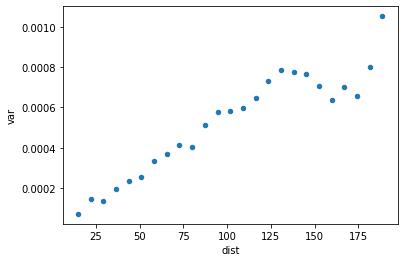

In [108]:
# pd.DataFrame({'x':x, 'v':v}).plot.scatter(x='x', y='v', s=.1)
df_bins.plot.scatter(x='dist', y='var')

Fit slope

In [145]:
from statsmodels.formula.api import ols
df_bins_filter = df_bins[:-6]
fit = ols(formula='var ~ dist', data=df_bins_filter).fit()
coefs = fit.params

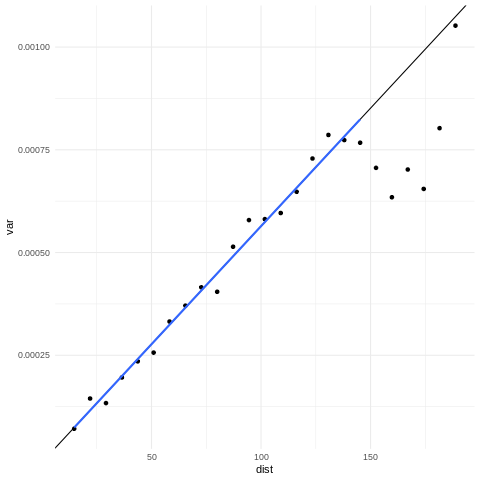

In [168]:
%%R -i coefs -i df_bins
df_bins %>%
ggplot(aes(x=dist, y=var)) + 
geom_point() +
geom_abline(intercept=coefs[1], slope=coefs[2]) +
geom_smooth(method='lm', data=df_bins[1:19,], se=F) +
theme_minimal()

Use smoothed variogram from brainsmash

In [96]:
from brainsmash.mapgen.base import Base
mapgen = Base(scores.values, D=distmat, pv=100)

<AxesSubplot:xlabel='distance', ylabel='variance'>

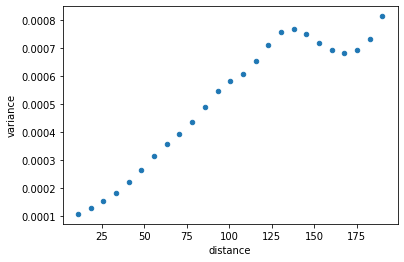

In [97]:
df_smoothed = pd.DataFrame({
    'distance':mapgen.h, 'variance':mapgen._smvar
    })
df_smoothed.plot.scatter(x='distance', y='variance')

In [70]:
mapgen.h

array([11.09006596, 13.46051212, 15.83095829, 18.20140445, 20.57185062,
       22.94229678, 25.31274295, 27.68318911, 30.05363528, 32.42408144,
       34.79452761, 37.16497378, 39.53541994, 41.90586611, 44.27631227,
       46.64675844, 49.0172046 , 51.38765077, 53.75809693, 56.1285431 ,
       58.49898926, 60.86943543, 63.23988159, 65.61032776, 67.98077393])

In [74]:
mapgen._smvar

masked_array(data=[7.024964777611568e-05, 7.749533501334485e-05,
                   8.239380158902521e-05, 9.715156380277043e-05,
                   0.00012404682939272008, 0.00015131153596904882,
                   0.0001588480445406481, 0.00014627243680595935,
                   0.00014198441293869675, 0.00016295369271335288,
                   0.00018845685461719208, 0.0001965418744176714,
                   0.00020221220618848982, 0.00021631312956514826,
                   0.000231965727115029, 0.000248719434717167,
                   0.00025925062756964305, 0.00026240490890955736,
                   0.00028306997015965947, 0.00031927848423907005,
                   0.000338013945168895, 0.0003453231661008294,
                   0.00036427049863302103, 0.0003800223430775135,
                   0.00037974147980422164],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                

In [7]:
dm_hcp_3d_ds5.scores

,0,1,2,3,4
label,,,,,
1,0.048562,-0.017332,0.011716,-0.007523,0.008120
4,0.046956,-0.014453,0.009135,-0.006174,0.005668
5,0.046606,-0.015486,0.007987,-0.005389,0.006393
6,0.037344,-0.012593,0.002961,-0.001983,0.000066
8,0.029015,0.011986,0.012585,0.002074,-0.001474
...,...,...,...,...,...
175,0.006646,-0.001760,-0.008464,0.003586,0.000382
176,-0.021886,-0.004622,-0.001691,0.000173,-0.005320
177,-0.020789,-0.001044,-0.005123,-0.001416,-0.003041


In [30]:
distmat = pd.read_csv('../data/LeftParcelGeodesicDistmat.txt', sep=' ', header=None).set_axis(range(1,181),axis=0).set_axis(range(1,181),axis=1)

In [42]:
(distmat.stack().to_frame().reset_index()
.set_axis(['A','B','dist'],axis=1)
.join(dm_hcp_3d_ds5.scores[0], on='A')
.join(dm_hcp_3d_ds5.scores[0], on='B', rsuffix='1')
)

,A,B,dist,0,01
0,1,1,0.000000,0.048562,0.048562
1,1,2,69.651810,0.048562,NaN
2,1,3,43.860626,0.048562,NaN
3,1,4,32.288414,0.048562,0.046956
4,1,5,38.241608,0.048562,0.046606
...,...,...,...,...,...
32395,180,176,132.399277,NaN,-0.021886
32396,180,177,155.254105,NaN,-0.020789
32397,180,178,97.601845,NaN,-0.029566
32398,180,179,18.185892,NaN,-0.029342
